# Synthetic magnetic data

This code calculates the total-field anomaly produced by a synthetic body. The synthetic data are calculated by using the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/).

### Import the required stuff

In [1]:
# Set PySide compatible APIs
import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
#comment this command if you want to create a new model
%matplotlib inline

In [3]:
import numpy as np
import cPickle as pickle
from IPython.display import Image as img
from fatiando import mesher, gridder
#from fatiando.gravmag import polyprism, transform
from fatiando.gravmag import transform
from fatiando.gravmag import _polyprism_numpy as polyprism
from fatiando.utils import ang2vec
from fatiando.vis import mpl, myv

### Create a synthetic body

The synthetic body is formed by four [polygonal prisms](http://www.fatiando.org/api/mesher.html#fatiando.mesher.PolygonalPrism). These prisms are vertically juxtaposed, the top of the shallowest prism is at 100 m, the bottom of the deepest prism is at 2100 m and the total magnetization of all prisms has intensity 10 A/m, inclination 13$^{\circ}$, and declination -27$^{\circ}$. The local-geomagnetic field is constant and has inclination 5$^{\circ}$ and declination 38$^{\circ}$. The x, y, and z axes of the Cartesian coordinate system point, respectively, to North, East and to depth.

In [4]:
#set a constant local-geomagnetic field
inc, dec = 5., 38. #in degrees

In [5]:
bounds = [-10000, 10000, -10000, 10000, 0, 5000]
area = bounds[:4]
depths = [100, 600, 1100, 1600, 2100]

In [6]:
#change this cell from `Raw NBConvert` to `Code` if you want to load a model
#by using the Python pickle module (https://docs.python.org/2/library/pickle.html)
with open('model.pickle') as f:
        model = pickle.load(f)

### Calculate the total-field anomaly at a constant plane

The synthetic total-field anomaly is calculated at a constant z<sub>0</sub> = -100 m, on a regular grid of 141 $\times$ 80 points along, respectively, the x and y axes of the Cartesian coordinate system.

In [7]:
# grid of points (xp, yp, zp) on which the total-field anomaly is calculated
shape = (141, 80)
z0 = -100
xp, yp, zp = gridder.regular(area, shape, z=z0)

dx, dy = gridder.spacing(area, shape)

# total-field anomaly (in nT)
tf = polyprism.tf(xp, yp, zp, model, inc, dec)

In [8]:
print 'dx = %.5f \ndy = %.5f' % (dx, dy) 

dx = 142.85714 
dy = 253.16456


In [9]:
#Save the synthetic total-field anomaly in a txt file
header = """# Noise-free total-field anomaly calculated at z = {z} m, 
#on a regular grid of points
# shape (nx, ny): {shape}
# area [x1, x2, y1, y2]: {area}
# spacing (dx, dy): {spacing}
# x (m)    y (m)    z (m)    total-field anomaly (nT)
""".format(z=z0, shape=shape, area=area, spacing=(dx, dy))
file_name = 'tfanomaly_anomaly.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp, yp, zp, tf), fmt='%.5f')

In [10]:
#Save the synthetic total-field anomaly in a txt file
profile = (xp == 0.)
header = """# Noise-free total-field anomaly calculated at z = {z} m, 
#on the profile x = 0 m
# x (m)    y (m)    z (m)    total-field anomaly (nT)
""".format(z=z0)
file_name = 'tfanomaly_profile.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp[profile], yp[profile], zp[profile], tf[profile]), fmt='%.5f')

### Calculate the horizontal derivative of the total-field anomaly along the y-axis

The derivative is calculated numerically by using a central-difference approximation.

In [11]:
# total-field anomaly (in nT)
dytf = (polyprism.tf(xp, yp+10., zp, model, inc, dec) - \
        polyprism.tf(xp, yp-10., zp, model, inc, dec))/20.

In [12]:
#Save the derivative of the synthetic total-field anomaly in a txt file
header = """# Noise-free derivative of the total-field anomaly calculated at z = {z} m, 
#on a regular grid of points
# shape (nx, ny): {shape}
# area [x1, x2, y1, y2]: {area}
# spacing (dx, dy): {spacing}
# x (m)    y (m)    z (m)    deriv. total-field anomaly (nT/m)
""".format(z=z0, shape=shape, area=area, spacing=(dx, dy))
file_name = 'dytfanomaly_anomaly.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp, yp, zp, dytf), fmt='%.5f')

In [13]:
#Save the derivative of the synthetic total-field anomaly in a txt file
profile = (xp == 0.)
header = """# Noise-free derivative of the total-field anomaly calculated at z = {z} m, 
#on the profile x = 0 m
# x (m)    y (m)    z (m)    total-field anomaly (nT/m)
""".format(z=z0)
file_name = 'dytfanomaly_profile.txt'
with open(file_name, 'w') as f:
    f.write(header)
    np.savetxt(f, zip(xp[profile], yp[profile], zp[profile], dytf[profile]), fmt='%.5f')

### Plot the synthetic data

Anomaly map

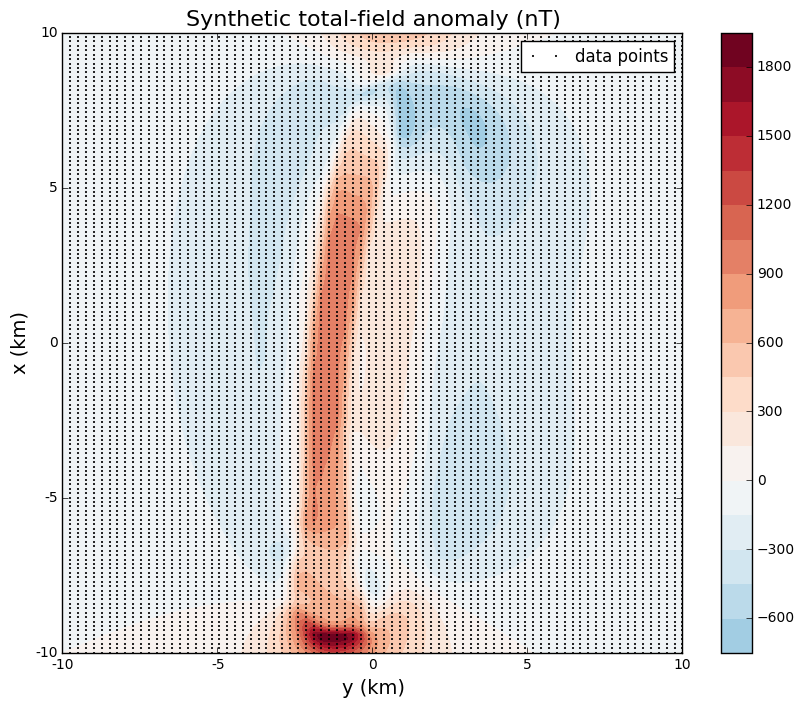

In [14]:
ranges = np.max(np.abs([np.min(tf), np.max(tf)]))
mpl.figure(figsize=(10,8))
mpl.axis('scaled')
mpl.title("Synthetic total-field anomaly (nT)", fontsize=16)
mpl.contourf(yp, xp, tf, shape, 20, cmap=mpl.get_cmap('RdBu_r'),
            vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.plot(yp, xp, '.k', markersize=2, label='data points')
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('x (km)', fontsize=14)
mpl.set_area(area)
mpl.legend(loc='upper right')
mpl.m2km()
mpl.savefig('map.png')
mpl.show()

Profile at x = 0 m

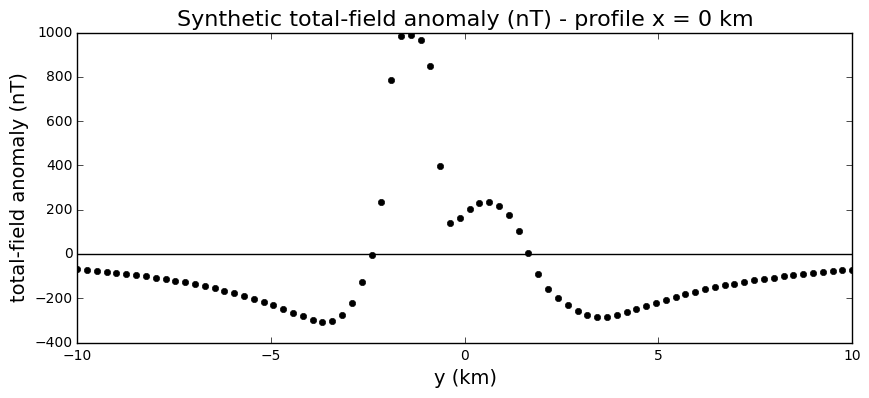

In [15]:
mpl.figure(figsize=(10,4))
mpl.title("Synthetic total-field anomaly (nT) - profile x = 0 km", fontsize=16)
mpl.plot(area[2:4], [0., 0.], '-k')
mpl.plot(0.001*yp[profile], tf[profile], '.k', markersize=10)
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('total-field anomaly (nT)', fontsize=14)
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.savefig('profile.png')
mpl.show()

Derivative of the total-field anomaly along y

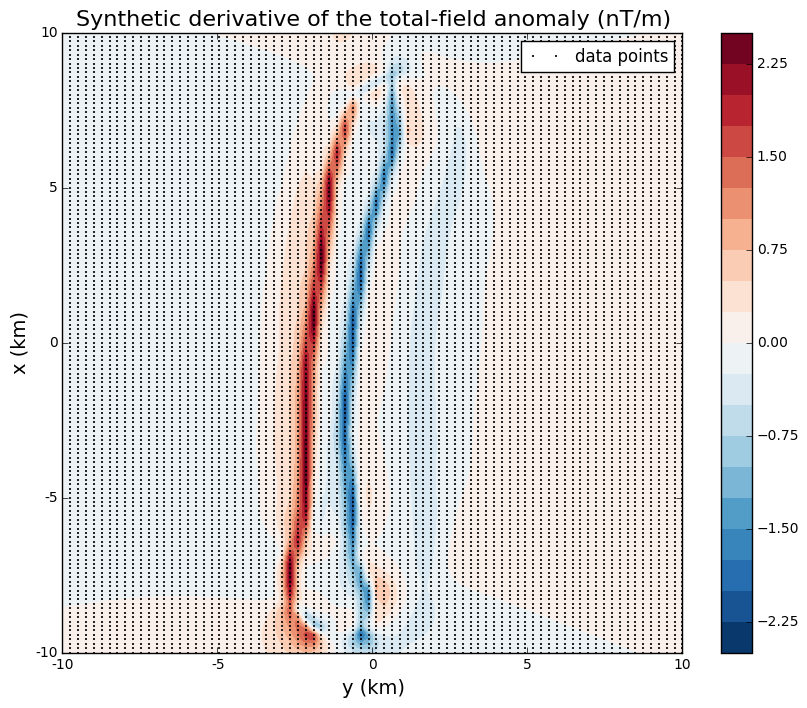

In [16]:
ranges = np.max(np.abs([np.min(dytf), np.max(dytf)]))
mpl.figure(figsize=(10,8))
mpl.axis('scaled')
mpl.title("Synthetic derivative of the total-field anomaly (nT/m)", fontsize=16)
mpl.contourf(yp, xp, dytf, shape, 20, cmap=mpl.get_cmap('RdBu_r'),
            vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.plot(yp, xp, '.k', markersize=2, label='data points')
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('x (km)', fontsize=14)
mpl.set_area(area)
mpl.legend(loc='upper right')
mpl.m2km()
mpl.savefig('map_dy.png')
mpl.show()

Profile of the derivative at x = 0 m

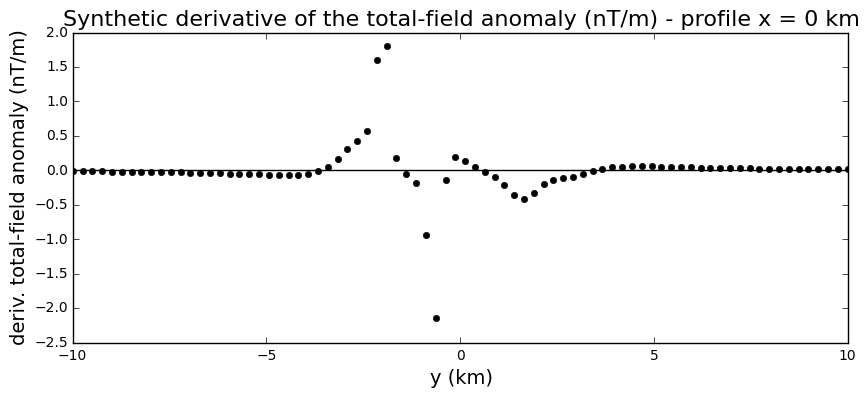

In [17]:
mpl.figure(figsize=(10,4))
mpl.title("Synthetic derivative of the total-field anomaly (nT/m) - profile x = 0 km", fontsize=16)
mpl.plot(area[2:4], [0., 0.], '-k')
mpl.plot(0.001*yp[profile], dytf[profile], '.k', markersize=10)
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('deriv. total-field anomaly (nT/m)', fontsize=14)
mpl.xlim(0.001*area[2], 0.001*area[3])
mpl.savefig('profile_dy.png')
mpl.show()

### Plot the synthetic body

In [18]:
# Show the model
scene=myv.figure(size=(600,500))
myv.polyprisms(model, 'magnetization')
myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])

scene.scene.camera.position = [-45893.530845938621, -15145.201752891464, -25039.48539632967]
scene.scene.camera.focal_point = [-444.56066945604118, -2065.8995815899721, 1099.9999999999832]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.48341530978694358, 0.064881785059688557, -0.87298338599944825]
scene.scene.camera.clipping_range = [31071.114118358404, 86583.208366893625]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()

myv.savefig('model.png')
myv.show()

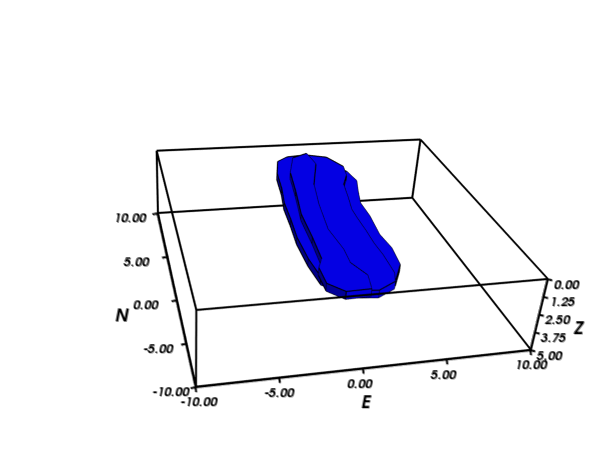

In [19]:
img('model.png')

### Laplaciano 

In [20]:
tfxx = transform.derivx(xp, yp, tf, shape, order=2, method='fft')
tfyy = transform.derivy(xp, yp, tf, shape, order=2, method='fft')
tfzz = transform.derivz(xp, yp, tf, shape, order=2, method='fft')

In [21]:
laplacian = tfxx + tfyy + tfzz

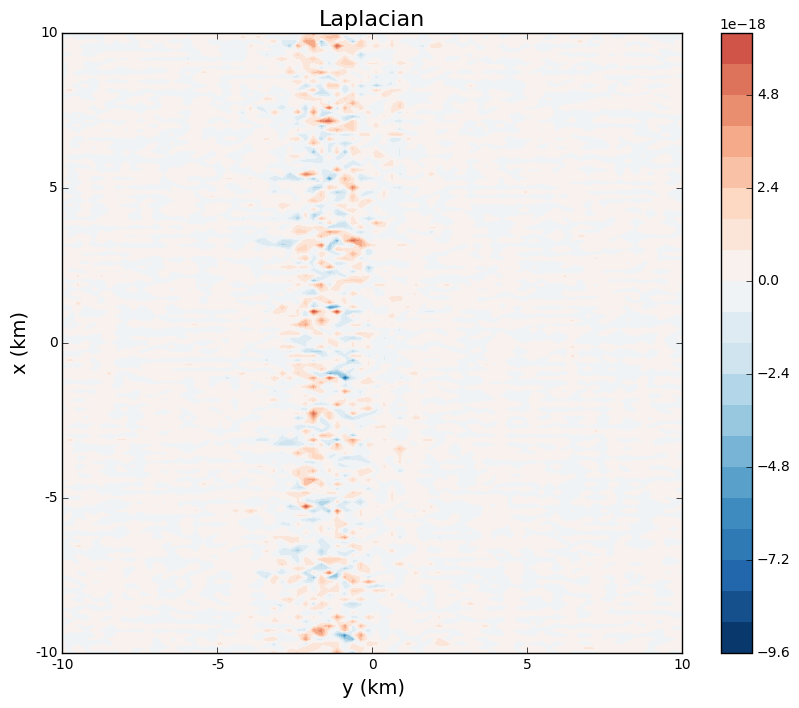

In [22]:
ranges = np.max(np.abs([np.min(laplacian), np.max(laplacian)]))
mpl.figure(figsize=(10,8))
mpl.axis('scaled')
mpl.title("Laplacian", fontsize=16)
mpl.contourf(yp, xp, laplacian, shape, 20, cmap=mpl.get_cmap('RdBu_r'),
            vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.xlabel('y (km)', fontsize=14)
mpl.ylabel('x (km)', fontsize=14)
mpl.set_area(area)
mpl.m2km()
mpl.savefig('laplacian_mag.png')
mpl.show()